# Gold Price Forecast based on LSTM-CNN Model

In [1]:
import attention
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import sklearn.preprocessing
import sklearn.model_selection
import tensorflow as tf

In [2]:
# Load dataset
df = pd.read_excel("data/gold-prices.xlsx", sheet_name="Daily", skiprows=8, usecols="D:AB", index_col="Name")

In [3]:
# Model settings
alpha = 7   # window length
beta = 1    # the number of LSTM layers
gamma = 64  # the number of filters in convolutional layer

In [4]:
prices = df['US dollar'].tolist()

# Split data
training_ratio = 0.8
n_train = int(len(prices) * training_ratio)
n_test = len(prices) - n_train

train_prices = np.array(prices[:n_train]).reshape((-1, 1))
test_prices = np.array(prices[n_train:n_train+n_test]).reshape((-1, 1))

# Standardize data
scaler = sklearn.preprocessing.StandardScaler()
scaler.fit(train_prices)
train_prices = scaler.transform(train_prices).reshape(-1)
test_prices = scaler.transform(test_prices).reshape(-1)

print("train_prices.shape:", train_prices.shape)
print("test_prices.shape:", test_prices.shape)

train_prices.shape: (8748,)
test_prices.shape: (2188,)


In [5]:
# make train dataset
X_train = []
y_train = []
for i in range(len(train_prices)-alpha):
    X_train.append(train_prices[i:i+alpha].reshape((1, -1)))
    y_train.append(train_prices[i+alpha].reshape((1, -1)))  # next day's price
X_train = np.array(X_train, dtype='float32')
y_train = np.array(y_train, dtype='float32')

# make test dataset
X_test = []
y_test = []
for i in range(len(test_prices)-alpha):
    X_test.append(test_prices[i:i+alpha].reshape((1, -1)))
    y_test.append(test_prices[i+alpha].reshape((1, -1)))  # next day's price
X_test = np.array(X_test, dtype='float32')
y_test = np.array(y_test, dtype='float32')

print("X_train.shape:", X_train.shape)
print("y_train.shape:", y_train.shape)
print("X_test.shape:", X_test.shape)
print("y_test.shape:", y_test.shape)

X_train.shape: (8741, 1, 7)
y_train.shape: (8741, 1, 1)
X_test.shape: (2181, 1, 7)
y_test.shape: (2181, 1, 1)


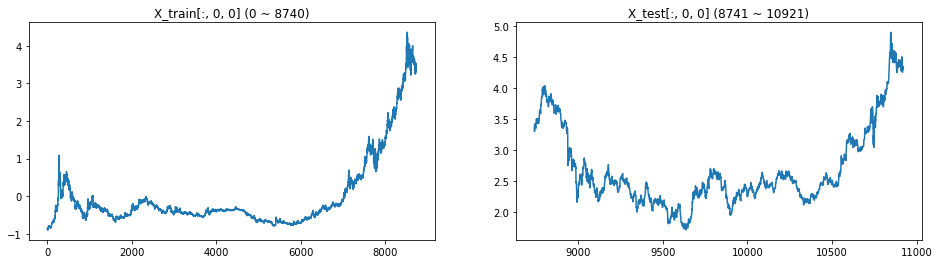

In [6]:
# Plot dataset
plt.figure(figsize=(16, 4))
plt.subplot(121)
plt.title("X_train[:, 0, 0] (%d ~ %d)" % (0, len(X_train)-1))
sns.lineplot(x=np.arange(0, len(X_train)), y=X_train[:, 0, 0])

plt.subplot(122)
plt.title("X_test[:, 0, 0] (%d ~ %d)" % (len(X_train), len(X_train)+len(X_test)-1))
sns.lineplot(x=np.arange(len(X_train), len(X_train)+len(X_test)), y=X_test[:, 0, 0])
plt.show()

In [7]:
model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(alpha, input_shape=(1, alpha), return_sequences=True) for _ in range(beta)
] + [
    attention.Attention(),
    tf.keras.layers.Dense(alpha, activation='linear'),
    tf.keras.layers.Reshape((1, alpha)),
    tf.keras.layers.Conv1D(filters=gamma, kernel_size=1, strides=1),
    tf.keras.layers.MaxPooling1D(pool_size=2, strides=1, padding='same'),
    tf.keras.layers.Dense(alpha, activation='relu'),
    tf.keras.layers.Dense(1, activation='linear'),
])

model.compile(optimizer='adam', loss='mse')
history = model.fit(X_train, y_train, batch_size=80, epochs=100)

Epoch 1/100
110/110 [==============================] - 0s 3ms/step - loss: 0.0931
Epoch 2/100
110/110 [==============================] - 0s 3ms/step - loss: 0.0031
Epoch 3/100
110/110 [==============================] - 0s 3ms/step - loss: 0.0022
Epoch 4/100
110/110 [==============================] - 0s 3ms/step - loss: 0.0021
Epoch 5/100
110/110 [==============================] - 0s 3ms/step - loss: 0.0018
Epoch 6/100
110/110 [==============================] - 0s 3ms/step - loss: 0.0015
Epoch 7/100
110/110 [==============================] - 0s 3ms/step - loss: 0.0015
Epoch 8/100
110/110 [==============================] - 0s 3ms/step - loss: 0.0014
Epoch 9/100
110/110 [==============================] - 0s 3ms/step - loss: 0.0016
Epoch 10/100
110/110 [==============================] - 0s 3ms/step - loss: 0.0014
Epoch 11/100
110/110 [==============================] - 0s 3ms/step - loss: 0.0012
Epoch 12/100
110/110 [==============================] - 0s 3ms/step - loss: 0.0012
Epoch 13/100


110/110 [==============================] - 0s 3ms/step - loss: 9.2246e-04
Epoch 98/100
110/110 [==============================] - 0s 3ms/step - loss: 8.5164e-04
Epoch 99/100
110/110 [==============================] - 0s 3ms/step - loss: 8.9546e-04
Epoch 100/100
110/110 [==============================] - 0s 3ms/step - loss: 0.0010


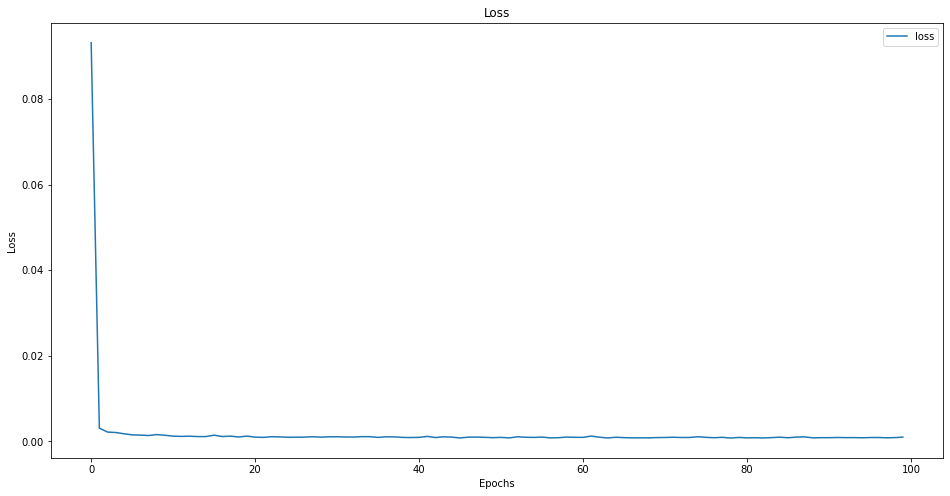

In [8]:
plt.figure(figsize=(16, 8))
sns.lineplot(data=history.history)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss")
plt.show()

In [9]:
preds = model.predict(X_test)

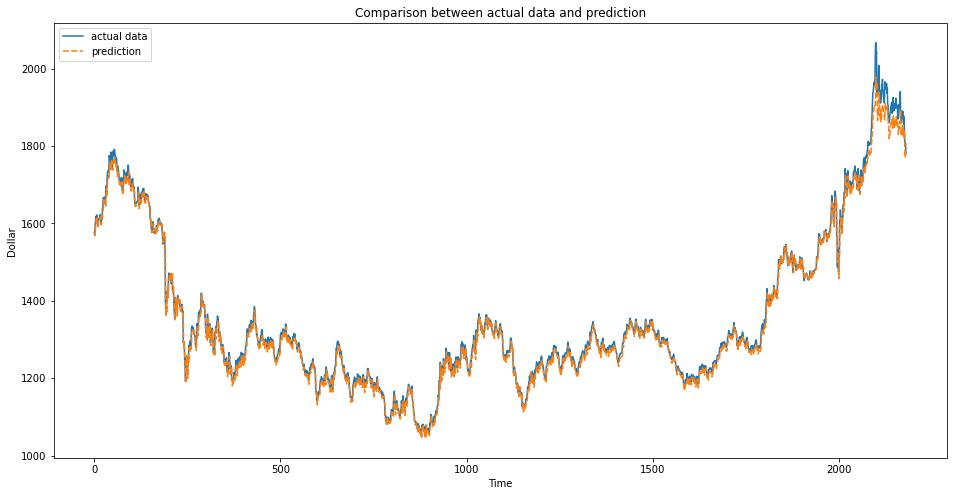

In [10]:
plt.figure(figsize=(16, 8))
sns.lineplot(data={
    "actual data": scaler.inverse_transform(y_test.reshape(-1, 1)).reshape(-1),
    "prediction": scaler.inverse_transform(preds.reshape(-1, 1)).reshape(-1),
})
plt.title("Comparison between actual data and prediction")
plt.xlabel("Time")
plt.ylabel("Dollar")
plt.show()